- 참고 : https://sieon-dev.tistory.com/15

## 1. 모듈 import (필요없는 모듈 삭제, 필요한 모듈 추가하면서 진행)
- pandas
- numpy
- matplotlib
- re
- konlpy
- tensorflow
- seaborn
- pandas_profiling

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import pandas_profiling

In [2]:
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
import collections
from collections import Counter

In [4]:
import exchange_calendars as ecals
import datetime
import time

In [5]:
import PIL

In [6]:
from wordcloud import WordCloud

In [7]:
import matplotlib as mpl

In [8]:
import nltk

### 1-1. 파이썬 & 모듈 버전 확인 (필요없는 모듈 삭제, 필요한 모듈 추가하면서 진행)

In [9]:
print(" python version : ", sys.version, "\n", "-" * 100)
print(" pandas version : ", pd.__version__, "\n", "-" * 100)
print(" numpy version : ", np.__version__, "\n", "-" * 100)
print(" re version : ", re.__version__, "\n", "-" * 100)
print(" tensorflow version : ", tensorflow.__version__, "\n", "-" * 100)
print(" seaborn version : ", sns.__version__, "\n", "-" * 100)
print(" pandas_profiling version : ", pandas_profiling.__version__, "\n", "-" * 100)
print(" sklearn version : ", sklearn.__version__, "\n", "-" * 100)
print(" exhange_calendars version : ", ecals.__version__, "\n", "-" * 100)

 python version :  3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)] 
 ----------------------------------------------------------------------------------------------------
 pandas version :  1.2.4 
 ----------------------------------------------------------------------------------------------------
 numpy version :  1.20.1 
 ----------------------------------------------------------------------------------------------------
 re version :  2.2.1 
 ----------------------------------------------------------------------------------------------------
 tensorflow version :  2.3.0 
 ----------------------------------------------------------------------------------------------------
 seaborn version :  0.11.1 
 ----------------------------------------------------------------------------------------------------
 pandas_profiling version :  2.9.0 
 ----------------------------------------------------------------------------------------------------
 sklearn version :  0.24.1 
 --

### 1-2. 컴퓨터 사양 확인

![](2022-03-24-13-31-45.png)

## 2. 데이터 불러오기

In [10]:
# 뉴스데이터 불러오기
newsdata = pd.read_csv("../data/Newsfile3.csv", encoding='euc-kr')
newsdata.tail(3)

,date,title
58439,20151019,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,20151019,[반도체] 2016 반도체 투자 감소 예상 - 미래
58441,20151019,"제주반도체, '해외투자유치설' 조회공시 요구"


### 2-1. 휴장일 데이터 매칭

In [11]:
# newsdata의 datatype 확인
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  int64 
 1   title   58442 non-null  object
dtypes: int64(1), object(1)
memory usage: 913.3+ KB


- type 변환

In [12]:
# datatype : int -> string
newsdata = newsdata.astype({'date':'string'})
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  string
 1   title   58442 non-null  object
dtypes: object(1), string(1)
memory usage: 913.3+ KB


In [13]:
# datatype : string -> datetime
newsdata['date'] = pd.to_datetime(newsdata['date'])
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    58442 non-null  datetime64[ns]
 1   title   58442 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 913.3+ KB


- 뉴스데이터의 처음 날짜와 마지막 날짜 확인

In [14]:
first_date = newsdata['date'][0]
last_date = newsdata['date'][-1:]
print(first_date, last_date)

2022-03-16 00:00:00 58441   2015-10-19
Name: date, dtype: datetime64[ns]


In [15]:
# newsdata -> newsdata_all : 처음 날짜와 마지막 날짜가 포함된 데이터로 이름 변결
newsdata_all = newsdata[newsdata['date'].between('2015-10-19', '2022-03-16')]
newsdata_all

,date,title
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”"
3,2022-03-16,"[특징주] 코리아써키트, 반도체 패키지기판 성장 기대감에 5%↑"
4,2022-03-16,"[특징주] 반도체 대장주 강세…SK하이닉스, 2% 넘게 상승"
...,...,...
58437,2015-10-19,세계 반도체 M&A 1006억달러
58438,2015-10-19,반도체社 인수·합병 봇물…올 들어 1000억달러 돌파
58439,2015-10-19,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,2015-10-19,[반도체] 2016 반도체 투자 감소 예상 - 미래


- 리스트로 변환

In [16]:
# 'date' 컬럼 리스트로 변경
news = newsdata_all['date'].to_list()
news[:5]

[Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00'),
 Timestamp('2022-03-16 00:00:00')]

### 2-2. 한국 거래소 개장일 확인

In [17]:
# 한국코드
XKRX = ecals.get_calendar("XKRX")       
# 2021-01-01은 개장일인지 확인 : 'False' -> 휴장일 , 'True' -> 개장일
print("2021-01-01 개장 확인: ", XKRX.is_session('2021-01-01'))    
# 오늘(22-03-24)은 개장일인지 확인 :'False' -> 휴장일 , 'True' -> 개장일
print("오늘날짜 개장일 확인: ", XKRX.is_session(datetime.date.today().strftime('%Y-%m-%d')))  
# 다음 개장일은 언제인지 확인
print("다음 개장일 날짜 확인: ", XKRX.next_open(pd.Timestamp.today().strftime('%Y-%m-%d')))

2021-01-01 개장 확인:  False
오늘날짜 개장일 확인:  True
다음 개장일 날짜 확인:  2022-03-28 00:00:00+00:00


In [18]:
# 뉴스데이터 날짜 다음날에 해당하는 개장일 날짜 확인
next_open_list = []

for day in news:
    next_open_date = XKRX.next_open(day)
    next_open_list.append(next_open_date)

In [19]:
next_open_list[:5]

[Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC'),
 Timestamp('2022-03-17 00:00:00+0000', tz='UTC')]

In [20]:
# 뉴스나온 날짜 다음 개장일 컬럼 추가
newsdata_all['NextOpenDate'] = next_open_list
newsdata_all.head(3)

,date,title,NextOpenDate
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17 00:00:00+00:00
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17 00:00:00+00:00
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17 00:00:00+00:00


In [21]:
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   date          58442 non-null  datetime64[ns]     
 1   title         58442 non-null  object             
 2   NextOpenDate  58442 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), object(1)
memory usage: 1.8+ MB


- type 변환

In [22]:
newsdata_all = newsdata_all.astype({'NextOpenDate':'string'})
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          58442 non-null  datetime64[ns]
 1   title         58442 non-null  object        
 2   NextOpenDate  58442 non-null  string        
dtypes: datetime64[ns](1), object(1), string(1)
memory usage: 1.8+ MB


In [23]:
a = newsdata_all['NextOpenDate'][0]
b = a.split(' ')[0]
b

'2022-03-17'

In [24]:
newsdata_all['NextOpenDate'] = newsdata_all['NextOpenDate'].apply(lambda x: x.split(' ')[0])
newsdata_all.head(3)

,date,title,NextOpenDate
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17


In [25]:
newsdata_all['NextOpenDate'] = pd.to_datetime(newsdata_all['NextOpenDate'])
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          58442 non-null  datetime64[ns]
 1   title         58442 non-null  object        
 2   NextOpenDate  58442 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(1)
memory usage: 3.8+ MB


In [26]:
# 개장일 기준 'Year' 컬럼 추가
newsdata_all['NextOpenDateYear'] = newsdata_all['NextOpenDate'].dt.year
newsdata_all.head(3)

,date,title,NextOpenDate,NextOpenDateYear
0,2022-03-16,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자",2022-03-17,2022
1,2022-03-16,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”,2022-03-17,2022
2,2022-03-16,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”",2022-03-17,2022


In [27]:
# col의 인덱스 변경
col = newsdata_all.columns.to_numpy()
col

array(['date', 'title', 'NextOpenDate', 'NextOpenDateYear'], dtype=object)

In [28]:
col = col[[0,3,2,1]]
col

array(['date', 'NextOpenDateYear', 'NextOpenDate', 'title'], dtype=object)

In [29]:
newsdata_all = newsdata_all[col]
newsdata_all.head(3)

,date,NextOpenDateYear,NextOpenDate,title
0,2022-03-16,2022,2022-03-17,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,2022,2022-03-17,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”
2,2022-03-16,2022,2022-03-17,"“韓, 세계 2위 中수입시장 비중 줄어…반도체 외 돌파구 필요”"


## 3. 데이터 확인

In [30]:
# 데이터 갯수 : 58442개
# 컬럼 갯수 : 4개
newsdata_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58442 entries, 0 to 58441
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              58442 non-null  datetime64[ns]
 1   NextOpenDateYear  58442 non-null  int64         
 2   NextOpenDate      58442 non-null  datetime64[ns]
 3   title             58442 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 4.2+ MB


- 결측치 확인

In [31]:
# 결측치 확인
newsdata_all.isnull().sum()

date                0
NextOpenDateYear    0
NextOpenDate        0
title               0
dtype: int64

## 4. 기업별 '현재가', '당일종가-어제종가', '상승률', 'label' 데이터와 뉴스데이터 병합

### 4-1. 반도체 기업 데이터 불러오기 : 005290

In [32]:
df1 = pd.read_excel('../data/날짜현재가/005290.xlsx')
df1.head(2)

,Unnamed: 0,일자,현재가,당일종가-어제종가,상승률
0,0,20220314,31900,-1500,-0.047022
1,1,20220311,33400,-300,-0.008982


In [33]:
df1.drop(columns=['Unnamed: 0'], inplace=True)
df1.head(2)

,일자,현재가,당일종가-어제종가,상승률
0,20220314,31900,-1500,-0.047022
1,20220311,33400,-300,-0.008982


- 긍정 & 부정 라벨링
    - 상승률이 0보다 크면 `1`로 매칭
    - 상승률이 0보다 작으면 `0`으로 매칭

In [34]:
df1['label'] = df1.apply(lambda x: 1 if x['상승률'] >= 0 else 0, axis=1)
df1

,일자,현재가,당일종가-어제종가,상승률,label
0,20220314,31900,-1500,-0.047022,0
1,20220311,33400,-300,-0.008982,0
2,20220310,33700,550,0.016320,1
3,20220308,33150,-800,-0.024133,0
4,20220307,33950,-1700,-0.050074,0
...,...,...,...,...,...
5479,19991227,8800,940,0.106818,1
5480,19991224,7860,840,0.106870,1
5481,19991223,7020,750,0.106838,1
5482,19991222,6270,670,0.106858,1


- 라벨링 분포 확인

<AxesSubplot:xlabel='label', ylabel='count'>

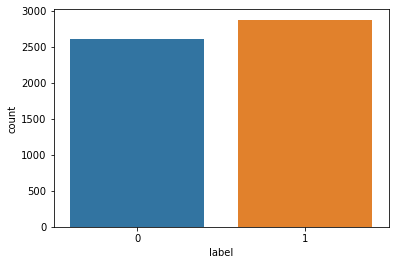

In [35]:
sns.countplot(x='label', data=df1)

- data type 변경

In [36]:
# data type : int -> string
df1 = df1.astype({'일자':'string'})
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         5484 non-null   string 
 1   현재가        5484 non-null   int64  
 2   당일종가-어제종가  5484 non-null   int64  
 3   상승률        5484 non-null   float64
 4   label      5484 non-null   int64  
dtypes: float64(1), int64(3), string(1)
memory usage: 214.3 KB


In [37]:
# data type : string -> datetime
df1['일자'] = pd.to_datetime(df1['일자'])
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5484 entries, 0 to 5483
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   일자         5484 non-null   datetime64[ns]
 1   현재가        5484 non-null   int64         
 2   당일종가-어제종가  5484 non-null   int64         
 3   상승률        5484 non-null   float64       
 4   label      5484 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 214.3 KB


### 4-2. 뉴스데이터 컬럼명 변경

In [38]:
# 덕산네오룩스의 데이터프레임과 병합하기 위해 컬럼명 변경
newsdata_all.rename(columns={'NextOpenDate':'일자'}, inplace=True)
newsdata_all.head(2)

,date,NextOpenDateYear,일자,title
0,2022-03-16,2022,2022-03-17,"유럽 반도체 공급망 지원 호응… 인텔, 10년간 110조 통큰 투자"
1,2022-03-16,2022,2022-03-17,반도체 또다시 ‘쩐의 전쟁‘…인텔 “유럽 전역에 110조 투자”


### 4-3. 뉴스데이터와 덕산네오룩스 주가데이터 병합

In [39]:
merge_data = pd.merge(newsdata_all, df1, on='일자', how='inner')
merge_data.head(2)

,date,NextOpenDateYear,일자,title,현재가,당일종가-어제종가,상승률,label
0,2022-03-13,2022,2022-03-14,전함 포템킨·오데사·네온사인…반도체는 왜 또 위기일까[인더독],31900,-1500,-0.047022,0
1,2022-03-13,2022,2022-03-14,"한국기업, 반도체·전자 부품 조달 ‘빨간불’",31900,-1500,-0.047022,0


- '일자', 'title', 'label'만 남긴 나머지 컬럼 삭제

In [40]:
merge_data = merge_data[['일자', 'title', 'label']]
merge_data.head(5)

,일자,title,label
0,2022-03-14,전함 포템킨·오데사·네온사인…반도체는 왜 또 위기일까[인더독],0
1,2022-03-14,"한국기업, 반도체·전자 부품 조달 ‘빨간불’",0
2,2022-03-14,“삼성·SK만 잘하면 뭐해?” 한국 반도체 진짜 ‘약점’이 바로 [비즈360],0
3,2022-03-14,"""반도체 일본꼴 날 수도…수도권 대학 반도체학과 정원 풀어야"" [당선인에 바란다]",0
4,2022-03-14,"[우크라 침공] 러시아, 반도체소자 등 500개 품목 대외수출 금지·제한",0


## 5. 데이터 전처리
    - 한글 이외의 문자열은 빈칸(`''`)처리
    - 품사 중 명사만 추출하여 'nouns' 컬럼에 삽입

In [119]:
okt = Okt()
n_ = []
title_rename = []

for i in range(len(merge_data)):
    if (i % 10000 == 0):
        print(i, "단계 완료")
    title_rename.append(re.sub("[\(\[].*?[\)\]]", "", merge_data.iloc[i]['title']))
    n_.append(' '.join(okt.nouns(merge_data.iloc[i]['title'])))
merge_data['nouns'] = n_
merge_data['title'] = title_rename
merge_data = merge_data[merge_data['nouns'] != '']

# 2차 불용어 제거
merge_data['title'] = merge_data['title'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]','')
merge_data['title'].replace('', np.nan, inplace=True)
merge_data = merge_data.dropna(how='any')

0 단계 완료
10000 단계 완료
20000 단계 완료
30000 단계 완료
40000 단계 완료
50000 단계 완료


In [123]:
merge_data.head(3)

,일자,title,label,nouns
0,2022-03-14,전함포템킨오데사네온사인반도체는왜또위기일까인더독,0,전함 포템킨 오데사 네온사인 반도체 왜또 위기 인 더독
1,2022-03-14,한국기업반도체전자부품조달빨간불,0,한국 기업 반도체 전자부품 조달 불
2,2022-03-14,삼성만잘하면뭐해한국반도체진짜약점이바로비즈,0,삼성 뭐해 한국 반도체 진짜 약점 이바 비즈


In [68]:
news_labeling = merge_data.copy()

In [55]:
# 결측치 확인
news_labeling.dropna(how='any', inplace=True)
news_labeling.shape

(58343, 4)

- label 분포 확인

<AxesSubplot:xlabel='label', ylabel='count'>

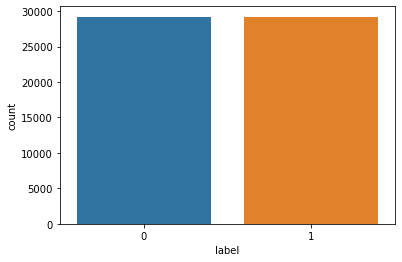

In [56]:
sns.countplot(x='label', data=news_labeling)

In [57]:
# 라벨링 값 개수 확인
news_labeling['label'].value_counts()

1    29202
0    29141
Name: label, dtype: int64

## 6. train_data, test_data 분할

In [58]:
# train, test set 분리
train_data, test_data = train_test_split(news_labeling)

### 6-1. train_data

In [59]:
# train_data 확인
train_data.head(2)

,일자,title,label,nouns
6378,2021-10-06,반도체공급망불안에삼성전자공장단낸드속도낸다,0,"(반도체, 공급망, 불안, 삼성, 전자, 공장, 단, 낸드, 속도)"
44437,2018-03-20,테크윙하이닉스와억원반도체장비공급계약,0,"(테크, 윙, 하이닉스, 반도체, 장비, 공급, 계약)"


In [60]:
# train_data shape 확인
train_data.shape

(43757, 4)

### 6-2. test_data

In [61]:
# test_data 확인
test_data.head(2)

,일자,title,label,nouns
26689,2019-12-13,삼성전자시안반도체공장에조억추가투자,1,"(삼성, 전자, 시안, 반도체, 공장, 추가, 투자)"
21999,2020-07-06,일본급소라며찔렀지만한국반도체더강해졌다,1,"(일본, 급소, 라며, 한국, 반도체, 더)"


In [62]:
# test_data shape 확인
test_data.shape

(14586, 4)

## 7. 감성사전 구축

- 한 글자인 단어는 제외. 두 글자 이상인 단어들의 점수 초기화 진행

In [63]:
vocab = {}
count = 0
for i in train_data['nouns']:
    # train_data에 있는 데이터의 양만큼 순회
    for j in range(len(i)):
        # i 번째 행의 리스트에 있는 j번째 단어의 길이가 1 이하일 경우 count에 1 추가
        if i[j] in vocab or len(i[j]) <= 1:
            count += 1
            pass
        else:
            # i 번째 행의 리스트에 있는 j번째 단어의 길이가 1 이상일 경우 0
            vocab[i[j]] = 0

In [64]:
vocab

{'반도체': 0,
 '공급망': 0,
 '불안': 0,
 '삼성': 0,
 '전자': 0,
 '공장': 0,
 '낸드': 0,
 '속도': 0,
 '테크': 0,
 '하이닉스': 0,
 '장비': 0,
 '공급': 0,
 '계약': 0,
 '업황': 0,
 '중기': 0,
 '최저': 0,
 '통과': 0,
 '목표': 0,
 '중국': 0,
 '시안': 0,
 '여명': 0,
 '급파': 0,
 '종합': 0,
 '수출': 0,
 '개월': 0,
 '연속': 0,
 '순항': 0,
 '최대': 0,
 '실적': 0,
 '견인': 0,
 '제재': 0,
 '화웨이': 0,
 '사실': 0,
 '중단': 0,
 '방한': 0,
 '대표': 0,
 '통상': 0,
 '논의': 0,
 '유니': 0,
 '테스트': 0,
 '규모': 0,
 '검사': 0,
 '체결': 0,
 '기흥': 0,
 '직원': 0,
 '확진': 0,
 '정상': 0,
 '가동': 0,
 '미래': 0,
 '산업': 0,
 '메카': 0,
 '화성시': 0,
 '바이오': 0,
 '생태계': 0,
 '가격': 0,
 '동반': 0,
 '하락': 0,
 '디스플레이': 0,
 '하반기': 0,
 '희비': 0,
 '영업': 0,
 '이익': 0,
 '시장': 0,
 '패러다임': 0,
 '슈퍼': 0,
 '히든': 0,
 '스토리': 0,
 '상반기': 0,
 '일자리': 0,
 '조선': 0,
 '고려': 0,
 '전일': 0,
 '대비': 0,
 '상승': 0,
 '회전': 0,
 '기록': 0,
 '올해': 0,
 '시스템': 0,
 '헬스': 0,
 '지원': 0,
 '연봉': 0,
 '절반': 0,
 '성과급': 0,
 '육박': 0,
 '베트남': 0,
 '아시아': 0,
 '인재': 0,
 '양성': 0,
 '채용': 0,
 '세계대전': 0,
 '정부': 0,
 '절실': 0,
 '세계': 0,
 '최초': 0,
 '차원': 0,
 '적층': 0,
 '패키지': 0,
 '양산'

In [65]:
len(news_labeling['nouns'][0])

10

- 상승비율과 하락비율을 정의해준 다음 라벨 값이 1이면 하락 비율을 각 단어에 더해주고 라벨값이 0이면 상승 비율을 차감
- 라벨값이 1이면 상승인데 왜 상승 비율을 더해주지 않았을지 : 라벨값이 1인 데이터가 아닌 데이터보다 훨씬 많다면 해당 단어들의 점수가 너무 커져서 점수가 고르지 못한 감성사전이 만들어지기 때문에 정규화했기 때문

In [66]:
up = 29202
down = 29141

up_ratio = up/(up+down)
down_ratio = down/(up+down)

for i,w in enumerate(news_labeling['nouns']):
    w = w.split(' ')
    if (news_labeling.iloc[i]['updown']==1):
        for j in range(len(w)):
            noun = w[j]
            if len(noun)<=1:
              continue
            vocab[noun] = vocab[noun] + down_ratio
    else:
        for j in range(len(w)):
            noun = w[j]
            if len(noun)<=1:
              continue
            vocab[noun] = vocab[noun] - up_ratio

AttributeError: 'tuple' object has no attribute 'split'

## 9. 워드 클라우드

### 9-1. train_data

In [100]:
# train_data > nouns 컬럼 > 0번째 데이터의 단어 출력
train_data.nouns.to_list()[0]

['차세대', '반도체', '등', '산업', '기술자', '더', '필요']

In [101]:
# train_data의 길이 확인
len(train_data.nouns.to_list())

43757

- train_data의 'nouns' 데이터 합치기

In [102]:
# 'nouns' 컬럼 데이터 리스트로 변환
nouns_list_train = []

for i in range(0, len(train_data.nouns.to_list())):
    noun = train_data.nouns.to_list()[i]
    nouns_list_train.append(noun)

In [103]:
nouns_list_train[:5]

[['차세대', '반도체', '등', '산업', '기술자', '더', '필요'],
 ['마이크론', '화웨이', '거래', '재개', '반도체'],
 ['반도체', '힘', '경상수지', '흑자', '확대', '코로나', '여파', '적자', '가능성'],
 ['충남', '반도체', '수출', '감소', '세', '지속', '지난달', '기록'],
 ['뉴욕증시', '반도체', '주', '상승', '반전', '시장', '등', '호재', '작용']]

In [104]:
# 'nouns' 컬럼 데이터 단어 데이터 합치기
nouns_total_train = []

for i in range(0, len(nouns_list_train)):
    nouns_total_train += nouns_list_train[i]

In [105]:
nouns_total_train

['차세대',
 '반도체',
 '등',
 '산업',
 '기술자',
 '더',
 '필요',
 '마이크론',
 '화웨이',
 '거래',
 '재개',
 '반도체',
 '반도체',
 '힘',
 '경상수지',
 '흑자',
 '확대',
 '코로나',
 '여파',
 '적자',
 '가능성',
 '충남',
 '반도체',
 '수출',
 '감소',
 '세',
 '지속',
 '지난달',
 '기록',
 '뉴욕증시',
 '반도체',
 '주',
 '상승',
 '반전',
 '시장',
 '등',
 '호재',
 '작용',
 '주식시장',
 '황소',
 '랠리',
 '반도체',
 '유망',
 '기재부',
 '삼성',
 '전자',
 '반도체',
 '설비',
 '투자',
 '시',
 '공제',
 '삼성',
 '반도체',
 '브이',
 '세계',
 '최초',
 '단대',
 '낸드',
 '양산',
 '반도체',
 '수출',
 '물량',
 '사상',
 '최대',
 '새',
 '배',
 '점프',
 '반도체',
 '밀고',
 '폴',
 '더블',
 '폰',
 '삼성',
 '전자',
 '첫',
 '매출',
 '쌍끌이',
 '삼성',
 '전자',
 '내년',
 '반도체',
 '점유',
 '율',
 '확대',
 '잠정',
 '실적',
 '한미',
 '반도체',
 '작년',
 '매출',
 '액',
 '영업',
 '이익',
 '이재용',
 '부회장',
 '반도체',
 '장비',
 '업체',
 '방문',
 '기념',
 '촬영',
 '바이든',
 '첨단',
 '반도체',
 '재건',
 '말',
 '구형',
 '웨이퍼',
 '이유',
 '한미',
 '반도체',
 '하이닉스',
 '규모',
 '반도체',
 '장비',
 '공급',
 '정부',
 '시스템',
 '반도체',
 '투입',
 '이익',
 '덜',
 '오른',
 '섹터',
 '순위',
 '반도체',
 '반도체',
 '클러스터',
 '후보',
 '용인',
 '낙점',
 '발전',
 '일만',
 '리서치',
 '알음',
 '전력',
 '반도체',
 '개발',
 '긍정

In [106]:
# 가장 많이 나온 단어 100개 저장
counts = Counter(nouns_total_train)
tags = counts.most_common(30000)
tags

[('반도체', 45052),
 ('삼성', 9584),
 ('전자', 6607),
 ('수출', 4461),
 ('장비', 3579),
 ('투자', 3343),
 ('공급', 2914),
 ('하이닉스', 2702),
 ('계약', 2229),
 ('규모', 2156),
 ('실적', 1855),
 ('공장', 1767),
 ('주', 1750),
 ('영업', 1717),
 ('서울', 1625),
 ('산업', 1615),
 ('기업', 1609),
 ('등', 1593),
 ('한미', 1509),
 ('생산', 1441),
 ('최대', 1402),
 ('시스템', 1366),
 ('위', 1322),
 ('용', 1321),
 ('제조', 1297),
 ('기술', 1297),
 ('사업', 1271),
 ('전망', 1259),
 ('시장', 1223),
 ('매출', 1191),
 ('익', 1172),
 ('증가', 1151),
 ('종합', 1131),
 ('한국', 1091),
 ('내년', 1089),
 ('세계', 1077),
 ('소재', 1062),
 ('상승', 1035),
 ('감소', 1012),
 ('개월', 990),
 ('올해', 986),
 ('중국', 983),
 ('부진', 951),
 ('디스플레이', 949),
 ('부족', 947),
 ('글로벌', 926),
 ('성장', 922),
 ('하락', 922),
 ('호황', 913),
 ('업계', 913),
 ('메모리', 883),
 ('이재용', 876),
 ('이익', 859),
 ('특징', 804),
 ('업체', 790),
 ('정부', 785),
 ('지원', 751),
 ('차', 749),
 ('개발', 734),
 ('자동차', 734),
 ('코스닥', 732),
 ('현대차', 729),
 ('인텔', 703),
 ('협력', 702),
 ('검사', 675),
 ('회복', 665),
 ('가격', 663),
 ('차량', 660),
 

- 한글 폰트 사용

In [109]:
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

- 필요없는 단어 제거 : stopwords 설정

In [121]:
# 불용어 지정
stopwords = "램 사 액 첫 제 세 달 내년 반도체 분기 억 월 차 년 중 주 일 등 조 억원 용 익 위 개월 이재용 것 조원 초"
stop_list = stopwords.split()

# stop_list에 없는 단어만 추출 > 리스트를 만들 것
words_list = [word for word in nouns_total_train if word not in stop_list]

- 단어 빈도수 살펴보기

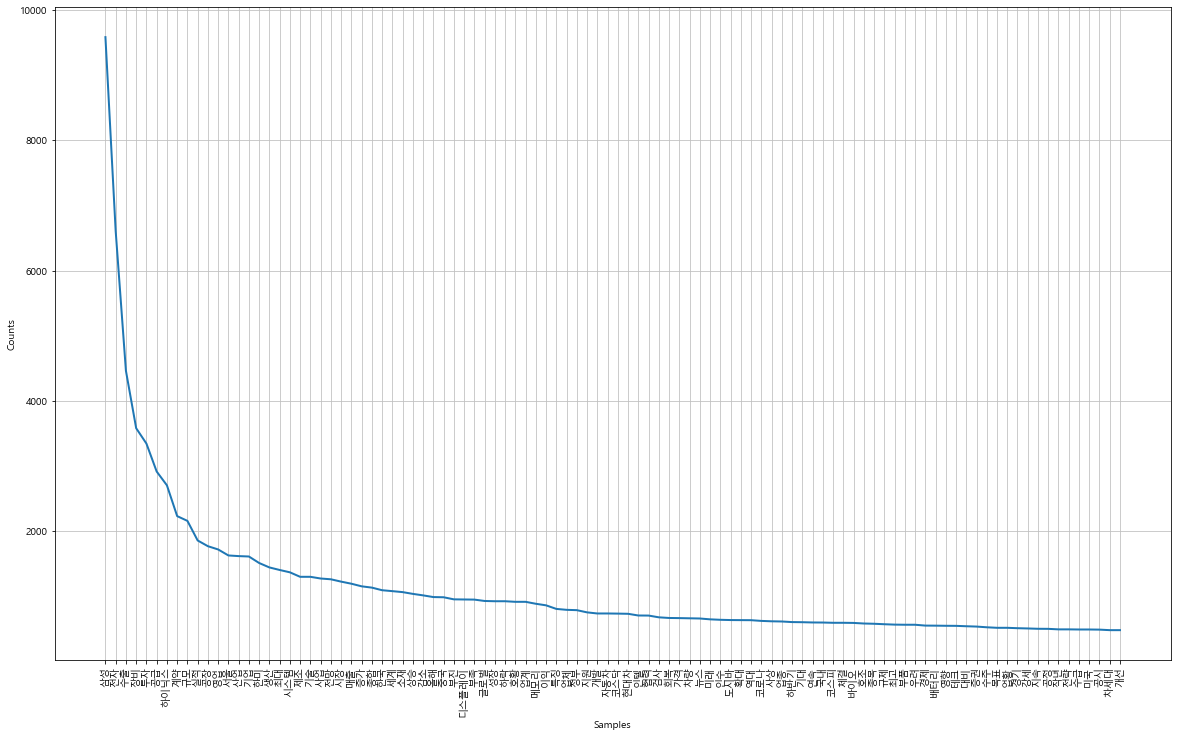

In [122]:
words = nltk.Text(words_list)
plt.figure(figsize=(20,12))
# 많이 사용된 단어 보여주기
words.plot(100)        
plt.show()

In [138]:
# 빈도수가 200 이상인 단어 10개
data = words.vocab().most_common(200)
data[:10]

[('삼성', 9584),
 ('전자', 6607),
 ('수출', 4461),
 ('장비', 3579),
 ('투자', 3343),
 ('공급', 2914),
 ('하이닉스', 2702),
 ('계약', 2229),
 ('규모', 2156),
 ('실적', 1855)]

- train_data 워드클라우드 생성

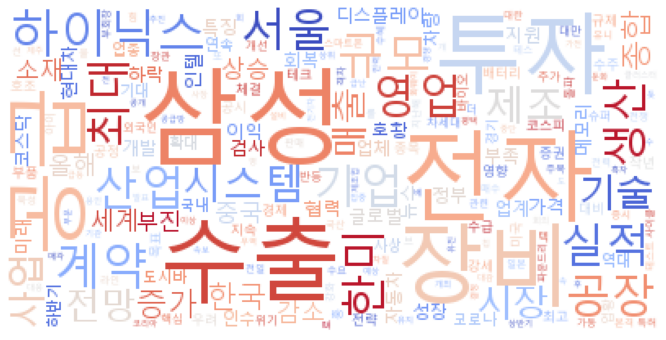

In [139]:
wc = WordCloud(
    font_path='c:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.2, background_color='white',
    colormap='coolwarm'
).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 9-2. test_data

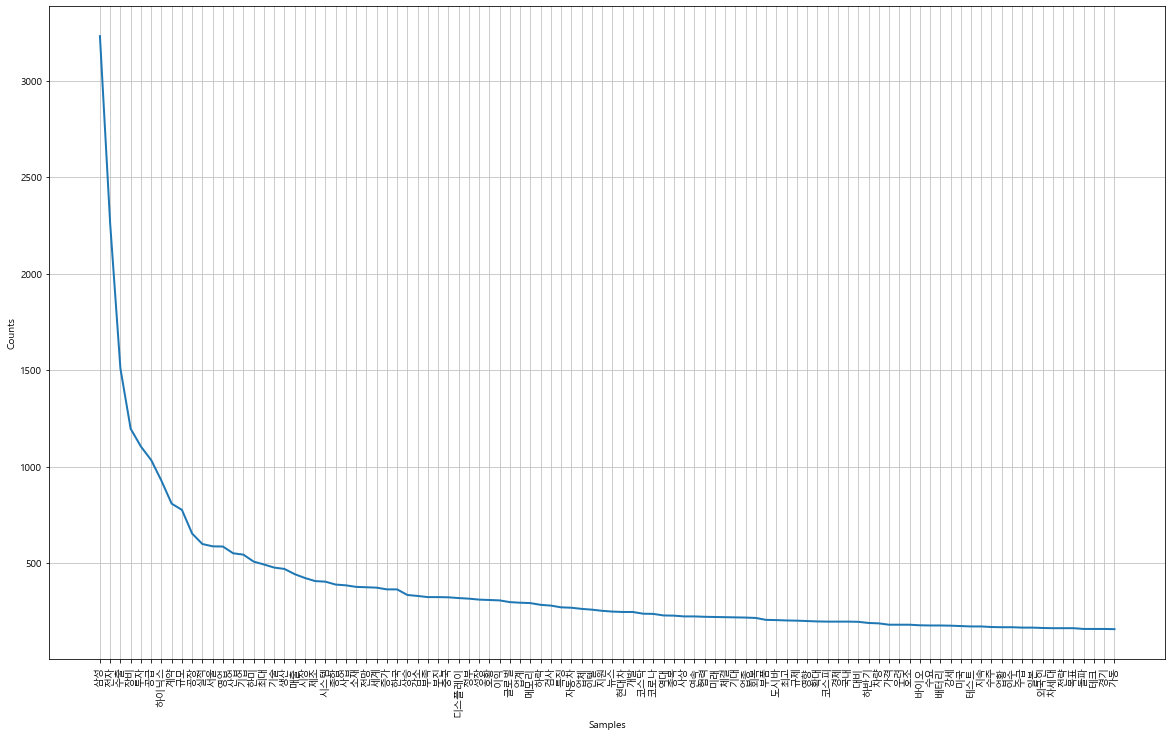

In [142]:
# test_data > nouns 컬럼 > 0번째 데이터의 단어
test_data.nouns.to_list()[0]


# 'nouns' 컬럼 데이터 리스트로 변환
nouns_list_test = []

for i in range(0, len(test_data.nouns.to_list())):
    noun = test_data.nouns.to_list()[i]
    nouns_list_test.append(noun)


# 'nouns' 컬럼 데이터 단어 데이터 합치기
nouns_total_test = []

for i in range(0, len(nouns_list_test)):
    nouns_total_test += nouns_list_test[i]

# 가장 많이 나온 단어 100개 저장
counts = Counter(nouns_total_test)
tags = counts.most_common(30000)
tags


# 불용어 지정
stopwords = "올해 작년 램 사 액 첫 제 세 달 내년 반도체 분기 억 월 차 년 중 주 일 등 조 억원 용 익 위 개월 이재용 것 조원 초"
stop_list = stopwords.split()

# stop_list에 없는 단어만 추출 > 리스트를 만들 것
words_list = [word for word in nouns_total_test if word not in stop_list]

words = nltk.Text(words_list)
plt.figure(figsize=(20,12))
# 많이 사용된 단어 보여주기
words.plot(100)        
plt.show()

In [143]:
# 빈도수가 200 이상인 단어 10개
data = words.vocab().most_common(200)
data[:10]

[('삼성', 3230),
 ('전자', 2258),
 ('수출', 1508),
 ('장비', 1196),
 ('투자', 1104),
 ('공급', 1034),
 ('하이닉스', 927),
 ('계약', 808),
 ('규모', 776),
 ('공장', 653)]

- test_data 워드클라우드 생성

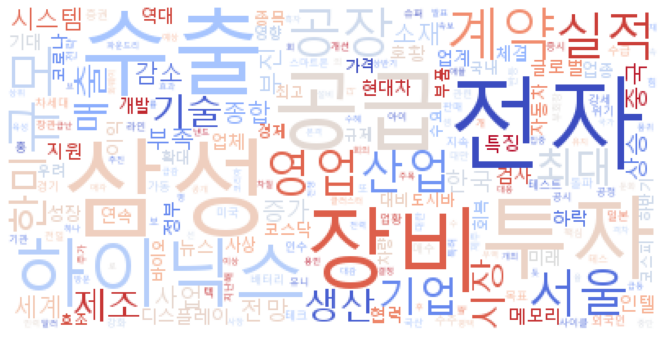

In [144]:
wc = WordCloud(
    font_path='c:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.2, background_color='white',
    colormap='coolwarm'
).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis('off')
plt.show()